In [1]:
import sys, os

sys.path.insert(0, '../../../node2vec')
sys.path.insert(0, '../../../residual2vec_')


In [2]:
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'
# checking if imports working
import node2vecs
from utils import snakemake_utils
from sklearn.decomposition import PCA
import pandas as pd 
from torch_geometric.data import download_url, extract_zip
import networkx as nx 
import numpy as np 
from scipy import sparse 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle as pkl

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
embs = pkl.load(open("../RESULTS/embs.pkl", "rb"))
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v'])

Using existing file polbooks.zip
Extracting /tmp/ashutiwa/polbooks.zip


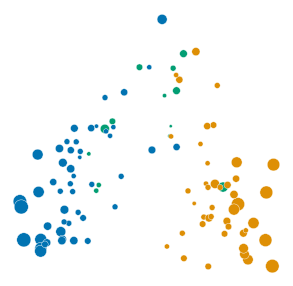

In [4]:
DIM = 16

extract_zip(download_url("http://www-personal.umich.edu/~mejn/netdata/polbooks.zip", "/tmp/ashutiwa/"), "/tmp/ashutiwa/", True)
DATA_FILE = '/tmp/ashutiwa/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)

def plot_embs(emb, degree, gp_ids, sizes=(10, 200), figsize=(5, 5)):
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data  = pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": gp_ids,
                "model": "Biased",
                "degree": degree
            }
        )

    # %%
    sns.set_style('white')
    sns.set(font_scale=1.0)
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=figsize)

    sns.scatterplot(data = plot_data, x = "x", y = "y", hue = "group", size = "degree", sizes=sizes, palette = sns.color_palette("colorblind", n_colors=3), ax = ax)
    ax.legend().remove()
    ax.axis("off")
    
deg = np.array(A.sum(axis=1)).reshape(-1)


plot_embs(emb=embs['Biased'], degree=deg, gp_ids=group_ids)



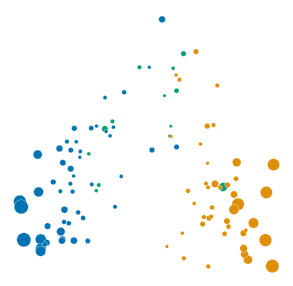

In [5]:
Aw = (sparse.diags(deg) @ A @ sparse.diags(deg)).todense()
deg = np.array(Aw.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['Biased'], degree=deg, gp_ids=group_ids)

In [6]:
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v'])

# only deepwalk here 

## gat r2v vs random

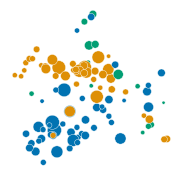

In [7]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gat_dw_r2v'], degree=deg, gp_ids=group_ids, figsize=(3, 3))

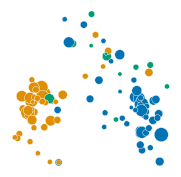

In [8]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gat_dw_random'], degree=deg, gp_ids=group_ids,  figsize=(3, 3))

## gcn r2v vs random

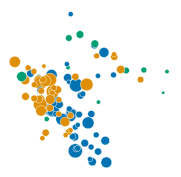

In [9]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gcn_dw_r2v'], degree=deg, gp_ids=group_ids, figsize=(3, 3))

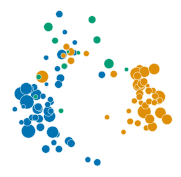

In [10]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gcn_dw_random'], degree=deg, gp_ids=group_ids,  figsize=(3, 3))

## word2vec r2v vs random

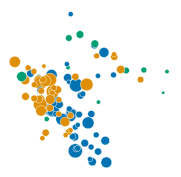

In [9]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gcn_dw_r2v'], degree=deg, gp_ids=group_ids, figsize=(3, 3))

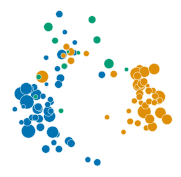

In [10]:
deg = np.array(A.sum(axis=1)).reshape(-1)
plot_embs(emb=embs['gcn_dw_random'], degree=deg, gp_ids=group_ids,  figsize=(3, 3))

## word2vec

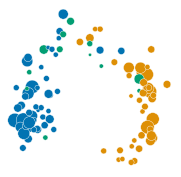

In [11]:
plot_embs(emb=embs['Degree-debiased'], degree=deg, gp_ids=group_ids, figsize=(3, 3))

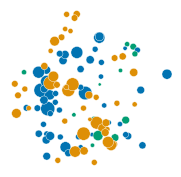

In [12]:
plot_embs(emb=embs['Degree-Group-debiased'], degree=deg, gp_ids=group_ids, figsize=(3, 3))